# Intel Scene Classification Challenge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing |Shift+Enter) will list the files in the input directory

import os
print(os.listdir("seg_train"))
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from sklearn.utils import shuffle
import seaborn as sns
import keras

['mountain', 'buildings', 'street', 'sea', 'forest', 'glacier']


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing |Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/My Drive/scene class 30"))
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from sklearn.utils import shuffle
import seaborn as sns
import keras

In [ ]:
def loadImages(root_dir,mode='train',labels_dict={'street':0,'sea':1,'glacier':2,'mountain':3,'buildings':4,'forest':5}):
    image_sizes=[]
    images=[]
    scene_type=[]
    if mode=='train':
        # Read the folders inside the root directory and the label is the name of the sub-directory
        for labels in os.listdir(root_dir):
            label=labels_dict[labels]
            for image_file in os.listdir(root_dir+"/"+labels):
                image = cv2.imread(root_dir+labels+r'/'+image_file)
                image_sizes.append(image.shape)
                ## There are images of multiple sizes in the data. Let us resize them
                
                image=cv2.resize(image,(150,150))
                images.append(image)
                scene_type.append(label)
        ### We need to shuffle the data set
        
        images,scenes= shuffle(images,scene_type,random_state=1234)
        
        ### Convert the list to numpy array 
        images=np.array(images)
        scenes=np.array(scenes)
        
        return images,scenes

In [ ]:
images,labels=loadImages("seg_train/")

In [ ]:
labels_dict={'street':0,'sea':1,'glacier':2,'mountain':3,'buildings':4,'forest':5}
inverse_labels={value:key for key,value in labels_dict.items()}

In [ ]:
TRAIN_DATASET_PATH="seg_train/"
import keras
from keras import models as Models
from keras import layers as Layers
from keras import optimizers as Optimizers
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, mode='train', ablation=None, image_cls={'street':0,'sea':1,'glacier':2,'mountain':3,'buildings':4,'forest':5}, 
                 batch_size=32, dim=(150, 150), n_channels=3, shuffle=True,train_test_split=0.8):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        # glob through directory of each class 
        label_class=[key for key,val in image_cls.items()]
        for i, cls in enumerate(label_class):
            paths = glob.glob(os.path.join(TRAIN_DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*train_test_split) #Divide the data into 80:20 - training and validation set
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_classes = len(label_class)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]


        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
       

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = cv2.imread(ID)
            img = img/255
            ## Resize the image
            img=cv2.resize(img,self.dim)
            X[i,] = img

            # Store class
            y[i] = self.labels[ID]
        
        
        return X, y            


In [ ]:
from keras.applications import VGG16

In [ ]:
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,input_shape=(150,150,3))


58892288/58889256 [==============================] - 66s 1us/step


In [ ]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model=Models.Sequential()
model.add(vgg_conv)
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               1474740   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

In [ ]:
vgg_conv.trainable=False

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               1474740   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

In [ ]:
model.compile(optimizer=Optimizers.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

training_generator=DataGenerator('train',train_test_split=0.7)
validation_generator=DataGenerator('val')
history=model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10)


Epoch 1/10
306/306 [==============================] - 662s 2s/step - loss: 0.8686 - accuracy: 0.6772 - val_loss: 0.3441 - val_accuracy: 0.8484
Epoch 2/10
306/306 [==============================] - 693s 2s/step - loss: 0.4952 - accuracy: 0.8336 - val_loss: 0.4352 - val_accuracy: 0.8671
Epoch 3/10
306/306 [==============================] - 691s 2s/step - loss: 0.4004 - accuracy: 0.8661 - val_loss: 0.4078 - val_accuracy: 0.8772
Epoch 4/10
306/306 [==============================] - 689s 2s/step - loss: 0.3563 - accuracy: 0.8866 - val_loss: 0.0836 - val_accuracy: 0.8836
Epoch 5/10
306/306 [==============================] - 694s 2s/step - loss: 0.3059 - accuracy: 0.8987 - val_loss: 0.3653 - val_accuracy: 0.8854
Epoch 6/10
306/306 [==============================] - 689s 2s/step - loss: 0.2762 - accuracy: 0.9112 - val_loss: 0.6168 - val_accuracy: 0.8847
Epoch 7/10
306/306 [==============================] - 689s 2s/step - loss: 0.2518 - accuracy: 0.9185 - val_loss: 0.6590 - val_accuracy: 0.885

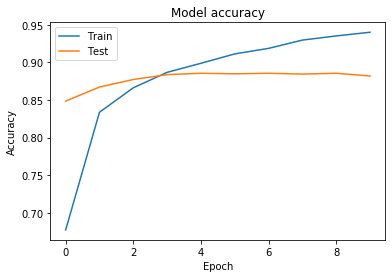

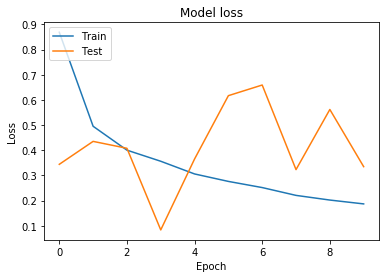

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
vgg_conv.trainable=True
set_trainable=False
for layer in vgg_conv.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable==True:
        layer.trainable=True
    else:
        layer.trainable=False


In [ ]:
model1=Models.Sequential()
model1.add(vgg_conv)
model1.add(Layers.Flatten())
model1.add(Layers.Dense(180,activation='relu'))
model1.add(Layers.Dense(100,activation='relu'))
model1.add(Layers.Dense(50,activation='relu'))
#model1.add(Layers.Dropout(rate=0.5))
model1.add(Layers.Dense(6,activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 180)               1474740   
_________________________________________________________________
dense_6 (Dense)              (None, 100)               18100     
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 306       
Total params: 16,212,884
Trainable params: 8,577,620
Non-trainable params: 7,635,264
___________________________________

In [ ]:
model1.compile(optimizer=Optimizers.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

training_generator=DataGenerator('train',train_test_split=0.7)
validation_generator=DataGenerator('val')
history=model1.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10)

Epoch 1/10
306/306 [==============================] - 787s 3s/step - loss: 0.7276 - accuracy: 0.7506 - val_loss: 0.2897 - val_accuracy: 0.8635
Epoch 2/10
306/306 [==============================] - 827s 3s/step - loss: 0.2895 - accuracy: 0.9025 - val_loss: 0.1947 - val_accuracy: 0.8865
Epoch 3/10
306/306 [==============================] - 808s 3s/step - loss: 0.2109 - accuracy: 0.9315 - val_loss: 0.3353 - val_accuracy: 0.8944
Epoch 4/10
306/306 [==============================] - 819s 3s/step - loss: 0.1651 - accuracy: 0.9461 - val_loss: 0.3285 - val_accuracy: 0.8983
Epoch 5/10
306/306 [==============================] - 813s 3s/step - loss: 0.1227 - accuracy: 0.9625 - val_loss: 0.1998 - val_accuracy: 0.9012
Epoch 6/10
306/306 [==============================] - 811s 3s/step - loss: 0.0932 - accuracy: 0.9745 - val_loss: 0.2594 - val_accuracy: 0.9041
Epoch 7/10
306/306 [==============================] - 803s 3s/step - loss: 0.0727 - accuracy: 0.9797 - val_loss: 0.4321 - val_accuracy: 0.8933

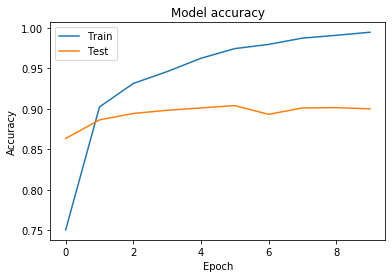

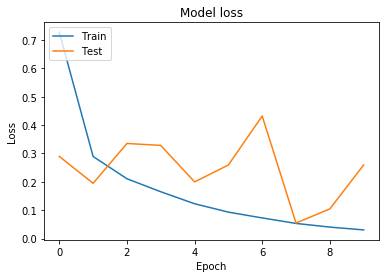

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
TEST_DATASET="seg_test/"

In [ ]:
test_images,test_labels=loadImages(TEST_DATASET)

In [ ]:
img_tensor=np.empty((len(test_images),150,150,3))
y=np.empty((len(test_images)),dtype=int)
y_pred=np.empty((len(test_images)),dtype=int)
for idx,img in enumerate(test_images):
    img = img/255
    ## Resize the image
    img=cv2.resize(img,(150,150))
    img_tensor[idx,] = img
    y[idx]=test_labels[idx]
    
y_pred=model1.predict_classes(img_tensor)

In [ ]:
y_pred

array([1, 3, 5, ..., 0, 4, 2])

In [ ]:
y

array([1, 3, 5, ..., 0, 4, 2])

In [ ]:
y_pred=list(y_pred)
y=list(y)

In [ ]:
y_pred=[inverse_labels[val] for val in y_pred]
y=[inverse_labels[val] for val in y]


In [ ]:
correct_pred=0
for idx in range(0,len(y)):
    
    if y[idx]==y_pred[idx]:
        correct_pred=correct_pred+1
    else:
        correct_pred=correct_pred
        
print("Number of Correct Predictions",correct_pred)

Number of Correct Predictions 2731


In [ ]:
acuuarcy=correct_pred/len(y)
print("Accuracy is",acuuarcy)


Accuracy is 0.9103333333333333


269


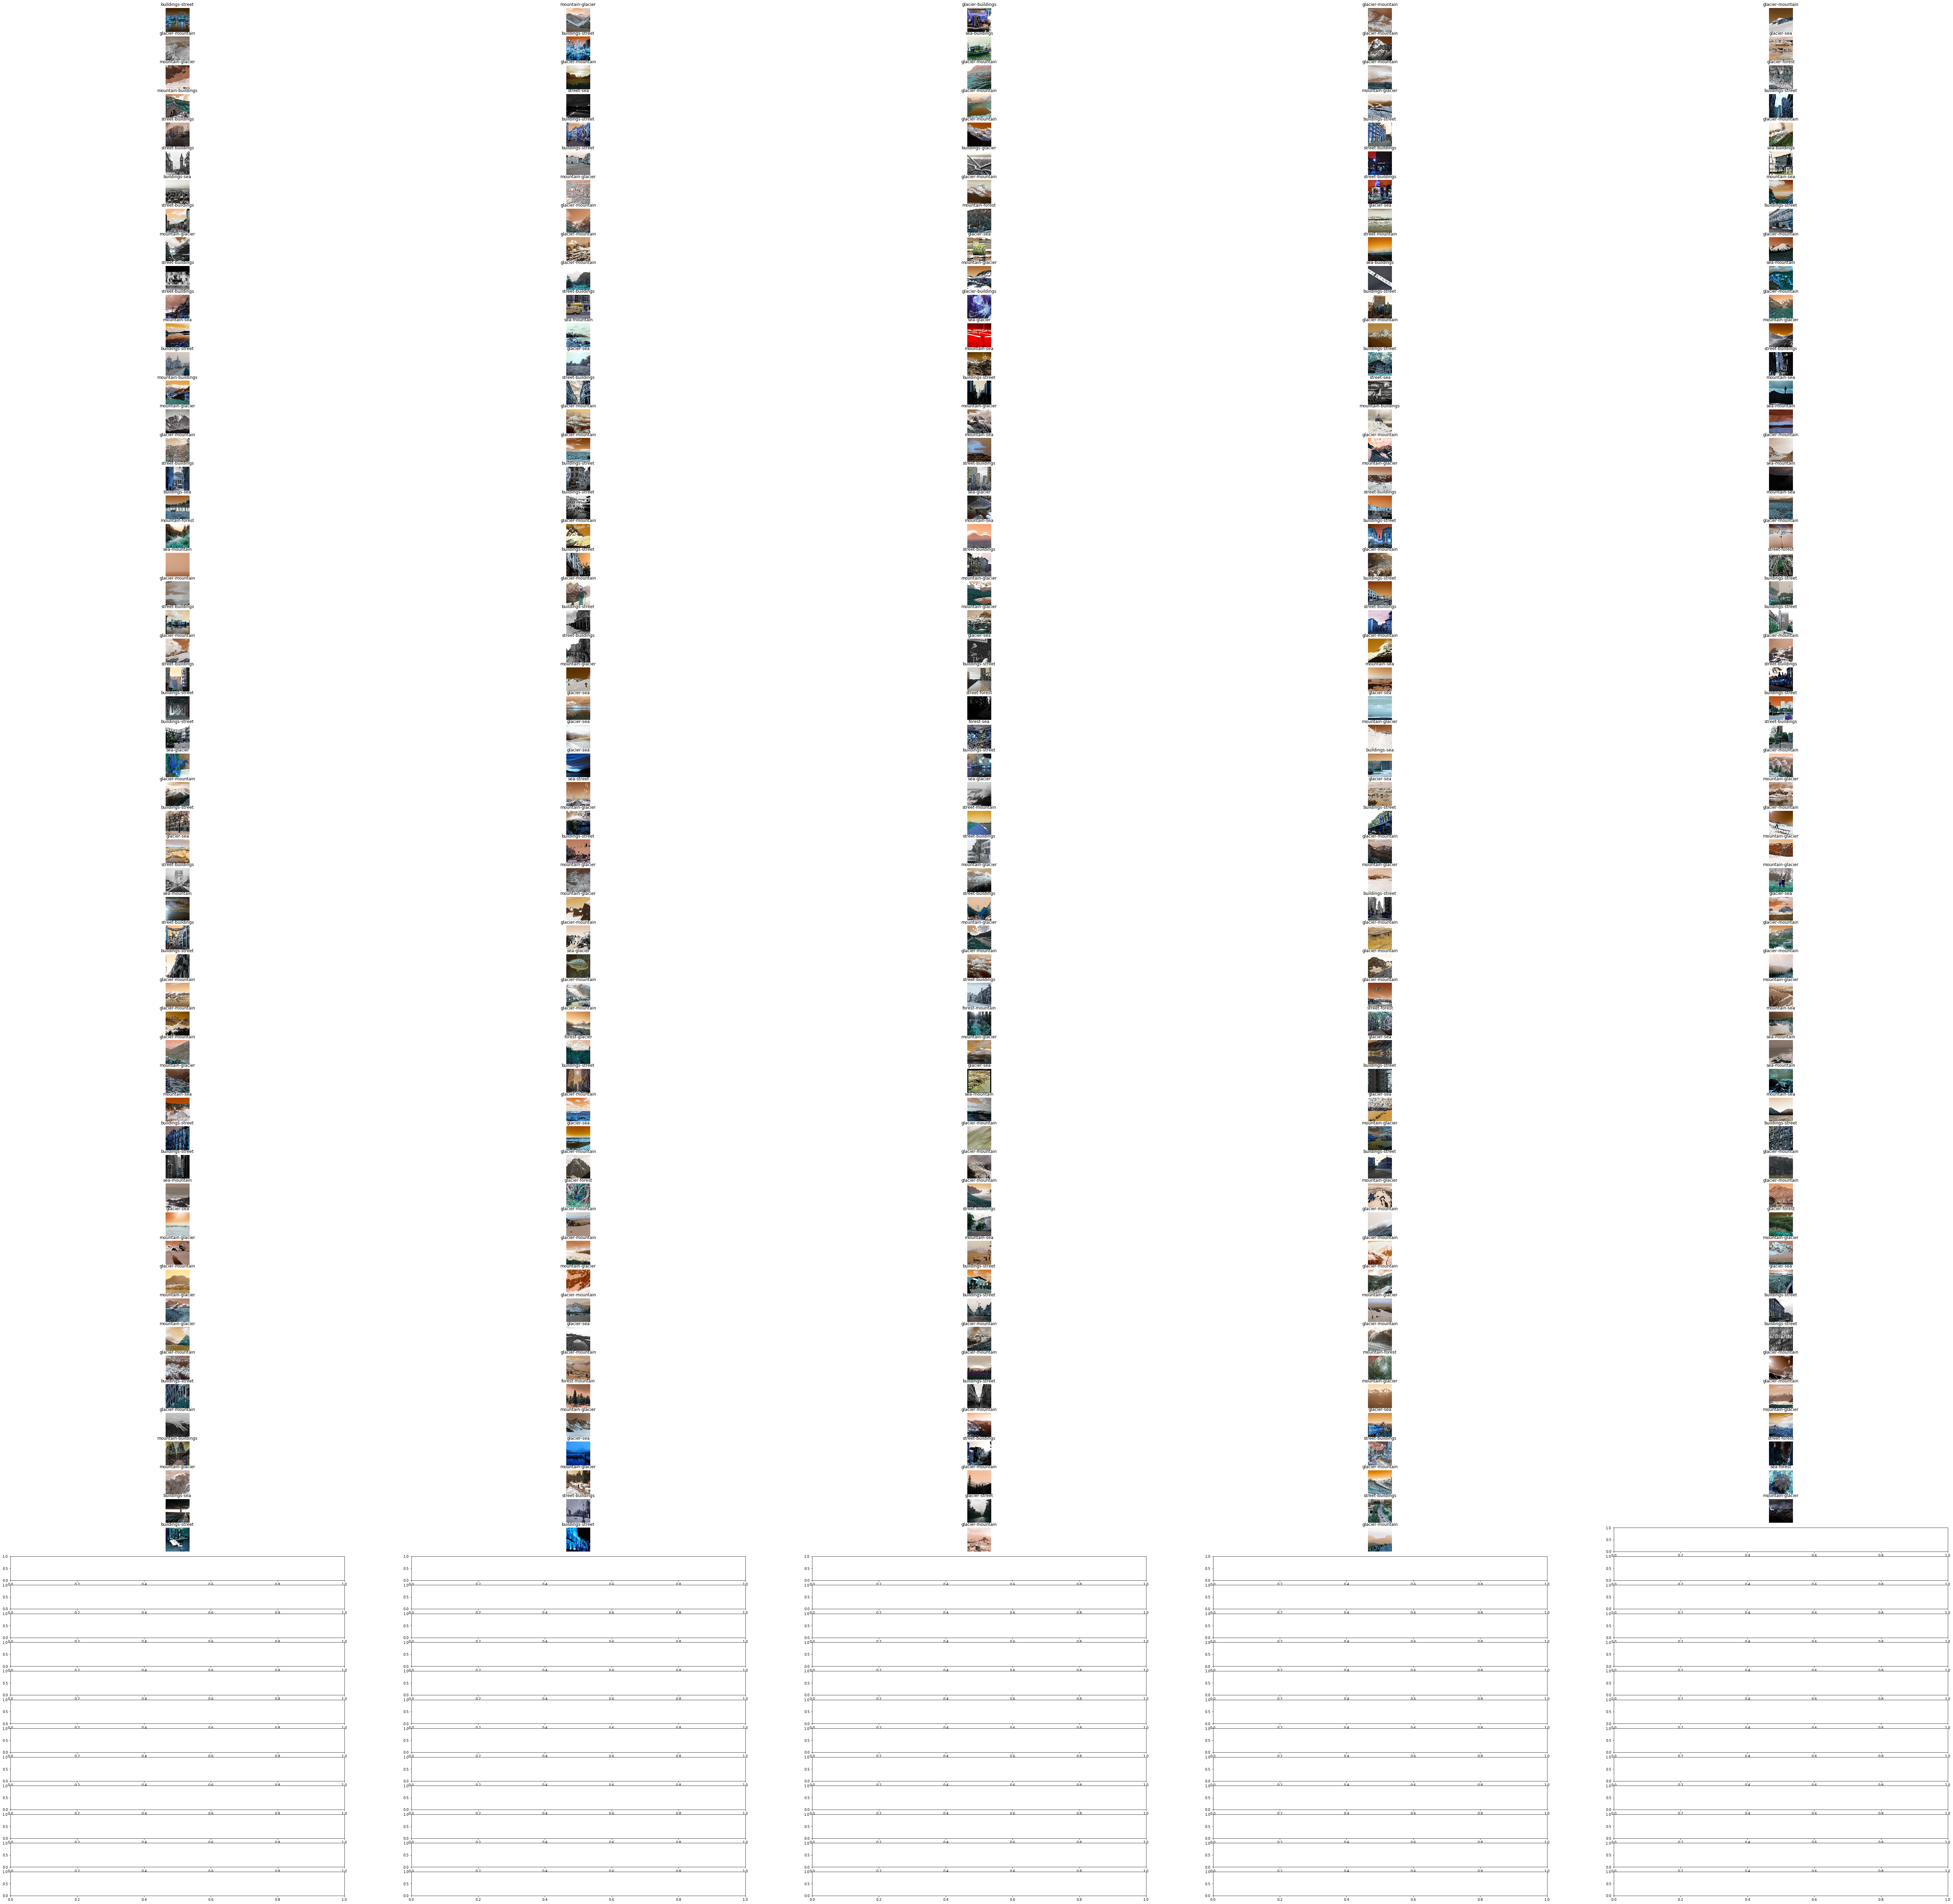

In [ ]:
f,ax = plt.subplots(66,5,figsize=(100,100)) 
#f.subplots_adjust(0,0,10,10)

incorrect_idx=[]
for idx in range(0,len(y)):
    if y[idx]!=y_pred[idx]:
        incorrect_idx.append(idx)

print(len(incorrect_idx))
for i in range(0,66,1):
    for j in range(0,5,1):
        if len(incorrect_idx)>0:
            idx=incorrect_idx.pop()
            ax[i,j].imshow(test_images[idx])
            ax[i,j].set_title(y[idx]+"-"+y_pred[idx])
            ax[i,j].axis('off')

In [ ]:
pip install model_evaluation_utils

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets


import matplotlib.pyplot as plt

In [ ]:
iris = datasets.load_iris()
X, y = iris.data, iris.target

y = label_binarize(y, classes=[0,1,2,3,4,5])
n_classes = 5


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()